# **Keras Tuner**

https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=ko

*하이퍼 파라미터 튜닝: 모델을 구성하는 여러 요소 중에 최적의 요소 값을 찾아내는 과정(epoch, learning rate등)

In [1]:
import tensorflow as tf
from tensorflow import keras
import IPython

In [2]:
!pip install -q -U keras-tuner
import kerastuner as kt

     |████████████████████████████████| 71kB 6.8MB/s 


In [3]:
#fashion MNIST 데이터 세트 준비
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

#0~1사이의 값으로 데이터 정규화
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

4423680/4422102 [==============================] - 0s 0us/step


**모델 정의하기**

In [13]:
#간단한 이미지 분류기 모델을 생성하는 함수 정의
#하이퍼 튜닝을 할 예정이기에 하이퍼 파라미터를 받을 인자 hp를 설정
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  #하이퍼 파라미터로 첫번째 밀집층의 뉴런개수를 32~512개 사의의 최적의 값으로 튜닝
  #정수값중 최적의 값을 찾는 것이므로 Int메서드를 사용하고 step을 정해준다.
  #step매개변수는 찾는 과정을 몇번 반복할지 정한다.
  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
  model.add(keras.layers.Dense(10))

  #하이퍼 파라미터로 learning rate값을 0.01,0.001,0.0001값중 최적의 값으로 튜닝
  #3개의 정해진 값중 하나의 값으로 선택하므로 Choice메소드를 사용
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                metrics = ['accuracy'])

  return model

#비교를 위한 임의 모델 생성 함수 정의
def model_builder_0():
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))
  model.add(keras.layers.Dense(32, activation = 'relu'))
  model.add(keras.layers.Dense(10))

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.01),
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                metrics = ['accuracy'])

  return model

**하이퍼 튜닝**

In [5]:
#튜너를 설정한다.
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3)

In [6]:
#훈련단계가 끝날때 마다 훈련결과를 지우는 콜백을 제작
#class선언문은 인자로 상속받을 클래스를 받는다.
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  #on_train_end 함수를 override하여 훈련결과를 지우도록 설정
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [7]:
#하이퍼 파라미터 탐색
tuner.search(img_train, label_train, epochs = 10, validation_data = (img_test, label_test), callbacks = [ClearTrainingOutput()])

#최적의 하이퍼 파라미터값을 받습니다.
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

Trial 30 Complete [00h 00m 34s]
val_accuracy: 0.8578000068664551

Best val_accuracy So Far: 0.8809000253677368
Total elapsed time: 00h 07m 00s
INFO:tensorflow:Oracle triggered exit


In [8]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 320 and the optimal learning rate for the optimizer
is 0.001.



In [9]:
#앞서 구한 최적의 파라미터로 모델을 재훈련
model = tuner.hypermodel.build(best_hps)
history = model.fit(img_train, label_train, epochs = 10, validation_data = (img_test, label_test))

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5970 - accuracy: 0.7902 - val_loss: 0.4490 - val_accuracy: 0.8399
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3737 - accuracy: 0.8627 - val_loss: 0.4016 - val_accuracy: 0.8599
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3282 - accuracy: 0.8798 - val_loss: 0.3648 - val_accuracy: 0.8711
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2940 - accuracy: 0.8910 - val_loss: 0.3517 - val_accuracy: 0.8728
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2775 - accuracy: 0.8984 - val_loss: 0.3429 - val_accuracy: 0.8746
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2614 - accuracy: 0.9025 - val_loss: 0.3426 - val_accuracy: 0.8736
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2525 - accuracy: 0.9056 - val_loss: 0.3440 - val_accuracy:

In [15]:
model2 = model_builder_0()
history2 = model2.fit(img_train, label_train, epochs = 10, validation_data = (img_test, label_test))

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7098 - accuracy: 0.7427 - val_loss: 0.4931 - val_accuracy: 0.8236
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4738 - accuracy: 0.8309 - val_loss: 0.5167 - val_accuracy: 0.8141
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4511 - accuracy: 0.8374 - val_loss: 0.4869 - val_accuracy: 0.8241
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4395 - accuracy: 0.8441 - val_loss: 0.4798 - val_accuracy: 0.8301
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4310 - accuracy: 0.8461 - val_loss: 0.5064 - val_accuracy: 0.8289
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4261 - accuracy: 0.8479 - val_loss: 0.5496 - val_accuracy: 0.8241
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4187 - accuracy: 0.8519 - val_loss: 0.5015 - val_accuracy:

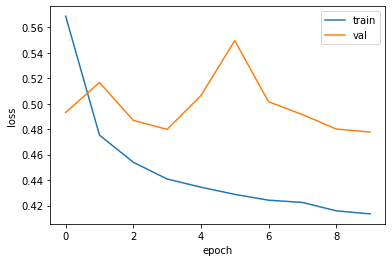

In [17]:
import matplotlib.pyplot as plt

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

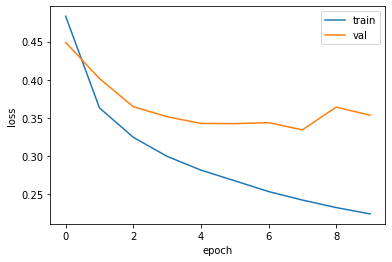

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()
#확연하게 향상된 성능을 볼 수 있다.